# Deliverable 3.1 - MPC Velocity Controllers for Stabilization

This notebook implements and tests MPC controllers for stabilizing the rocket's velocity in x, y, z directions and roll angle to zero.

In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget

In [2]:
# MPC import
import numpy as np
import matplotlib.pyplot as plt
from LinearMPC.MPCVelControl import MPCVelControl
from LinearMPC.MPCControl_xvel import MPCControl_xvel
from LinearMPC.MPCControl_yvel import MPCControl_yvel
from LinearMPC.MPCControl_zvel import MPCControl_zvel
from LinearMPC.MPCControl_roll import MPCControl_roll
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

## Design Procedure and Tuning Parameters

### Recursive Constraint Satisfaction

To ensure recursive feasibility and constraint satisfaction, we implement the following design:

1. **Terminal Controller**: We compute an LQR controller $K$ that stabilizes the system around the origin.

2. **Terminal Cost**: The LQR infinite-horizon cost $Q_f$ serves as our terminal cost, ensuring stability.

3. **Terminal Set**: We compute the maximal positively invariant set $\mathcal{X}_f$ for the closed-loop system under the LQR controller, subject to state and input constraints. This set is computed iteratively:
   - Start with $\Omega_0 = \mathcal{X} \cap K\mathcal{U}$
   - Iterate: $\Omega_{i+1} = \{x | A_{cl}x \in \Omega_i\} \cap \Omega_i$
   - Continue until $\Omega_{i+1} = \Omega_i$

4. **Constraint Formulation**: All constraints are formulated in delta coordinates $(\Delta x, \Delta u)$ relative to the trim point.

### Tuning Parameters

**Horizon**: $H = 4$ seconds (chosen to ensure settling time < 7 seconds)

**Controller-Specific Tuning**:

- **X-velocity controller**: $Q = \text{diag}(1, 20, 50)$, $R = 1$
  - Highest weight on velocity (index 2), medium on pitch angle (index 1), low on angular velocity
  
- **Y-velocity controller**: $Q = \text{diag}(1, 20, 50)$, $R = 1$
  - Similar structure to x-controller due to symmetry
  
- **Z-velocity controller**: $Q = 100$, $R = 1$
  - Very high weight on velocity due to critical nature of vertical control and safety constraints
  
- **Roll controller**: $Q = \text{diag}(1, 10)$, $R = 1$
  - Higher weight on roll angle than angular velocity

These weights were chosen to prioritize:
1. Velocity regulation (primary objective)
2. Angle constraints (must stay within linearization region)
3. Smooth control effort

In [3]:
# Setup parameters
Ts = 0.05  # Sampling time
H = 4.0    # Horizon in seconds

# Create rocket and controllers
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)

# Create individual controllers
mpc_x = MPCControl_xvel(A, B, xs, us, Ts, H)
mpc_y = MPCControl_yvel(A, B, xs, us, Ts, H)
mpc_z = MPCControl_zvel(A, B, xs, us, Ts, H)
mpc_roll = MPCControl_roll(A, B, xs, us, Ts, H)

print("Controllers created successfully!")
print(f"Horizon: {H}s, Sampling time: {Ts}s, Prediction steps: {int(H/Ts)}")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Controllers created successfully!
Horizon: 4.0s, Sampling time: 0.05s, Prediction steps: 80


## Terminal Invariant Sets

Below we visualize the terminal invariant sets for each controller. These sets guarantee that once the state enters them, it will remain feasible under the LQR control law while satisfying all constraints.

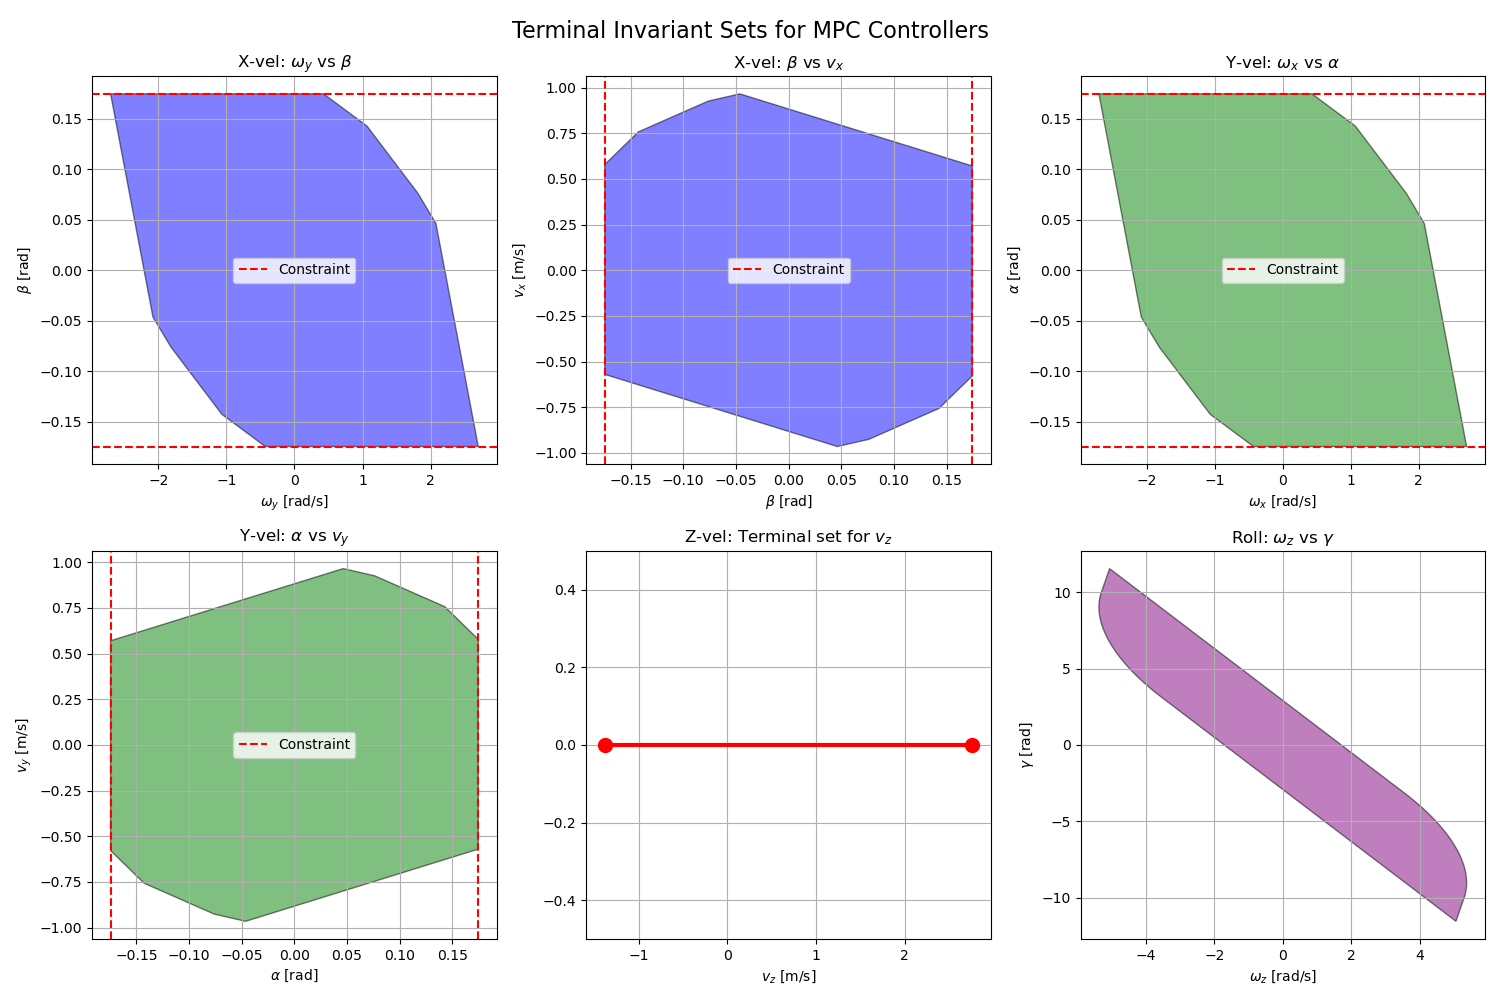


Terminal sets computed using maximal invariant set algorithm.
The sets show the region of attraction where the LQR controller maintains feasibility.


In [4]:
# Plot terminal sets for each controller
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Terminal Invariant Sets for MPC Controllers', fontsize=16)

# X-velocity controller (3D state: omega_y, beta, vx)
# Plot projections
ax = axes[0, 0]
Xf_x = mpc_x.Xf if hasattr(mpc_x, 'Xf') else None
if Xf_x is not None:
    try:
        Xf_x.projection(dims=(0,1)).plot(ax, color='blue', alpha=0.5)
        ax.set_xlabel(r'$\omega_y$ [rad/s]')
        ax.set_ylabel(r'$\beta$ [rad]')
        ax.set_title(r'X-vel: $\omega_y$ vs $\beta$')
        ax.grid(True)
        ax.axhline(y=0.1745, color='r', linestyle='--', label='Constraint')
        ax.axhline(y=-0.1745, color='r', linestyle='--')
        ax.legend()
    except Exception as e:
        ax.text(0.5, 0.5, f'Projection error: {str(e)[:30]}', ha='center', va='center')
        ax.set_title('X-vel: omega_y vs beta')

ax = axes[0, 1]
if Xf_x is not None:
    try:
        Xf_x.projection(dims=(1,2)).plot(ax, color='blue', alpha=0.5)
        ax.set_xlabel(r'$\beta$ [rad]')
        ax.set_ylabel(r'$v_x$ [m/s]')
        ax.set_title(r'X-vel: $\beta$ vs $v_x$')
        ax.grid(True)
        ax.axvline(x=0.1745, color='r', linestyle='--', label='Constraint')
        ax.axvline(x=-0.1745, color='r', linestyle='--')
        ax.legend()
    except Exception as e:
        ax.text(0.5, 0.5, f'Projection error: {str(e)[:30]}', ha='center', va='center')
        ax.set_title('X-vel: beta vs vx')

# Y-velocity controller (3D state: omega_x, alpha, vy)
ax = axes[0, 2]
Xf_y = mpc_y.Xf if hasattr(mpc_y, 'Xf') else None
if Xf_y is not None:
    try:
        Xf_y.projection(dims=(0,1)).plot(ax, color='green', alpha=0.5)
        ax.set_xlabel(r'$\omega_x$ [rad/s]')
        ax.set_ylabel(r'$\alpha$ [rad]')
        ax.set_title(r'Y-vel: $\omega_x$ vs $\alpha$')
        ax.grid(True)
        ax.axhline(y=0.1745, color='r', linestyle='--', label='Constraint')
        ax.axhline(y=-0.1745, color='r', linestyle='--')
        ax.legend()
    except Exception as e:
        ax.text(0.5, 0.5, f'Projection error: {str(e)[:30]}', ha='center', va='center')
        ax.set_title('Y-vel: omega_x vs alpha')

ax = axes[1, 0]
if Xf_y is not None:
    try:
        Xf_y.projection(dims=(1,2)).plot(ax, color='green', alpha=0.5)
        ax.set_xlabel(r'$\alpha$ [rad]')
        ax.set_ylabel(r'$v_y$ [m/s]')
        ax.set_title(r'Y-vel: $\alpha$ vs $v_y$')
        ax.grid(True)
        ax.axvline(x=0.1745, color='r', linestyle='--', label='Constraint')
        ax.axvline(x=-0.1745, color='r', linestyle='--')
        ax.legend()
    except Exception as e:
        ax.text(0.5, 0.5, f'Projection error: {str(e)[:30]}', ha='center', va='center')
        ax.set_title('Y-vel: alpha vs vy')

# Z-velocity controller (1D state: vz)
ax = axes[1, 1]
Xf_z = mpc_z.Xf if hasattr(mpc_z, 'Xf') else None
if Xf_z is not None:
    try:
        # For 1D, plot as line segment
        vz_min = np.min(Xf_z.V)
        vz_max = np.max(Xf_z.V)
        ax.plot([vz_min, vz_max], [0, 0], 'ro-', linewidth=3, markersize=10)
        ax.set_xlabel(r'$v_z$ [m/s]')
        ax.set_title(r'Z-vel: Terminal set for $v_z$')
        ax.grid(True)
        ax.set_ylim([-0.5, 0.5])
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)[:30]}', ha='center', va='center')
        ax.set_title('Z-vel: Terminal set')
else:
    ax.text(0.5, 0.5, 'Terminal set not available', ha='center', va='center')
    ax.set_title('Z-vel: Terminal set')

# Roll controller (2D state: omega_z, gamma)
ax = axes[1, 2]
Xf_roll = mpc_roll.Xf if hasattr(mpc_roll, 'Xf') else None
if Xf_roll is not None:
    try:
        Xf_roll.plot(ax, color='purple', alpha=0.5)
        ax.set_xlabel(r'$\omega_z$ [rad/s]')
        ax.set_ylabel(r'$\gamma$ [rad]')
        ax.set_title(r'Roll: $\omega_z$ vs $\gamma$')
        ax.grid(True)
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)[:30]}', ha='center', va='center')
        ax.set_title('Roll: Terminal set')
else:
    ax.text(0.5, 0.5, 'Terminal set not available', ha='center', va='center')
    ax.set_title('Roll: Terminal set')

plt.tight_layout()
plt.savefig('deliverable_3_1_terminal_sets.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTerminal sets computed using maximal invariant set algorithm.")
print("The sets show the region of attraction where the LQR controller maintains feasibility.")


### Why is the Z Terminal Set a Line?

The Z-velocity controller is a **1-dimensional system** with state $x = [v_z]$. For a 1D system:

- The terminal set $\mathcal{X}_f \subset \mathbb{R}^1$ is an interval $[v_z^{min}, v_z^{max}]$
- When plotted, this appears as a line segment on the real axis
- This is geometrically correct - a 1D set embedded in 1D space is indeed a line segment

The terminal set represents all velocities $v_z$ from which the LQR controller can stabilize the system to zero velocity while satisfying the critical throttle constraint $40 \leq P_{avg} \leq 80$.

In contrast:
- **Roll controller** (2D): Terminal set is a 2D polygon in $(\omega_z, \gamma)$ space
- **X/Y velocity controllers** (3D): Terminal sets are 3D polyhedra, shown as 2D projections
- **Z velocity controller** (1D): Terminal set is a 1D interval, shown as a line segment


## Open-Loop Predictions

We now test each controller separately with open-loop predictions to verify the optimization problem is correctly formulated.

X-controller initial control: [0.2618]
X-controller trajectory shape: states=(3, 81), inputs=(1, 80)


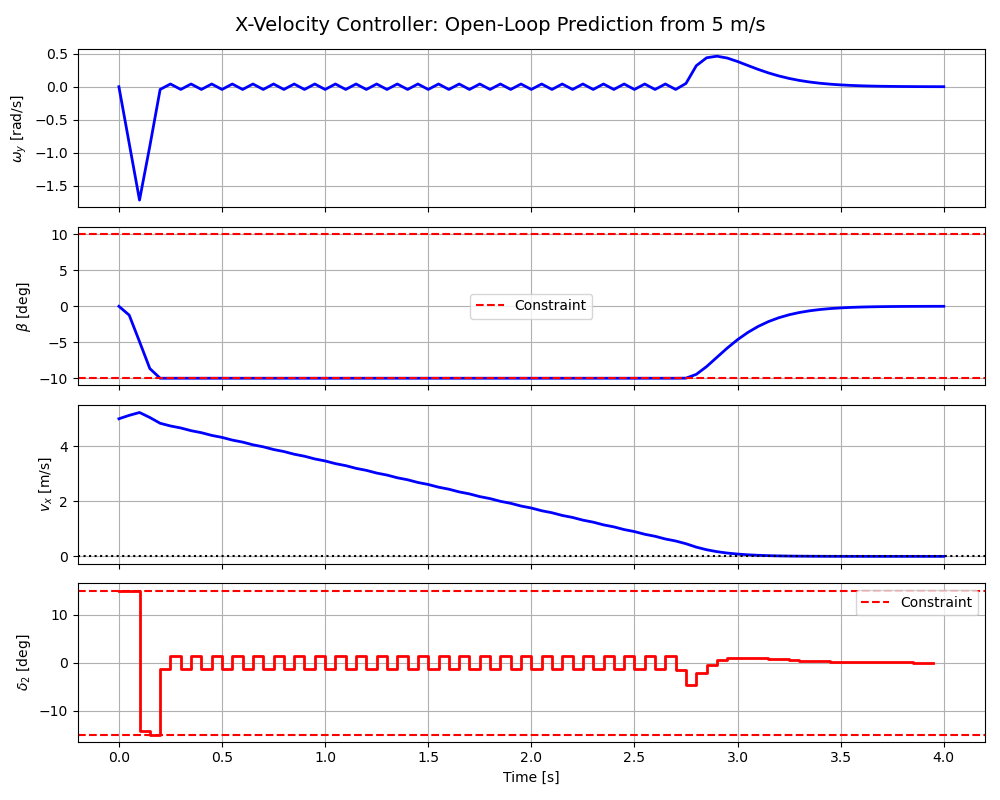

In [5]:
# Test X-velocity controller
# Initial state: [omega_y, beta, vx] = [0, 0, 5] (5 m/s in x direction)
x0_x = np.array([0.0, 0.0, 5.0])

u0_x, x_traj_x, u_traj_x = mpc_x.get_u(x0_x)

print(f"X-controller initial control: {u0_x}")
print(f"X-controller trajectory shape: states={x_traj_x.shape}, inputs={u_traj_x.shape}")

# Plot open-loop prediction
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('X-Velocity Controller: Open-Loop Prediction from 5 m/s', fontsize=14)

t = np.arange(x_traj_x.shape[1]) * Ts

axes[0].plot(t, x_traj_x[0, :], 'b-', linewidth=2)
axes[0].set_ylabel(r'$\omega_y$ [rad/s]')
axes[0].grid(True)

axes[1].plot(t, np.rad2deg(x_traj_x[1, :]), 'b-', linewidth=2)
axes[1].axhline(y=10, color='r', linestyle='--', label='Constraint')
axes[1].axhline(y=-10, color='r', linestyle='--')
axes[1].set_ylabel(r'$\beta$ [deg]')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t, x_traj_x[2, :], 'b-', linewidth=2)
axes[2].axhline(y=0, color='k', linestyle=':')
axes[2].set_ylabel(r'$v_x$ [m/s]')
axes[2].grid(True)

t_u = np.arange(u_traj_x.shape[1]) * Ts
axes[3].step(t_u, np.rad2deg(u_traj_x[0, :]), 'r-', linewidth=2, where='post')
axes[3].axhline(y=15, color='r', linestyle='--', label='Constraint')
axes[3].axhline(y=-15, color='r', linestyle='--')
axes[3].set_ylabel(r'$\delta_2$ [deg]')
axes[3].set_xlabel('Time [s]')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_1_x_openloop.png', dpi=150, bbox_inches='tight')
plt.show()

Y-controller initial control: [-0.2618]


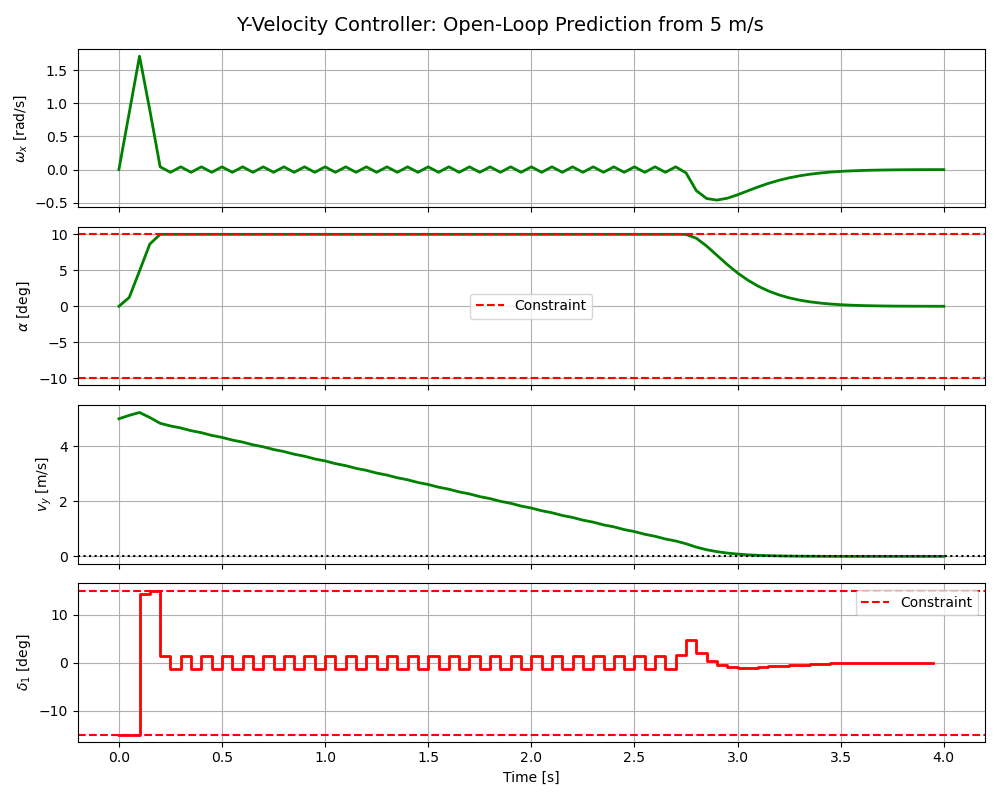

In [6]:
# Test Y-velocity controller
# Initial state: [omega_x, alpha, vy] = [0, 0, 5] (5 m/s in y direction)
x0_y = np.array([0.0, 0.0, 5.0])

u0_y, x_traj_y, u_traj_y = mpc_y.get_u(x0_y)

print(f"Y-controller initial control: {u0_y}")

# Plot open-loop prediction
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Y-Velocity Controller: Open-Loop Prediction from 5 m/s', fontsize=14)

t = np.arange(x_traj_y.shape[1]) * Ts

axes[0].plot(t, x_traj_y[0, :], 'g-', linewidth=2)
axes[0].set_ylabel(r'$\omega_x$ [rad/s]')
axes[0].grid(True)

axes[1].plot(t, np.rad2deg(x_traj_y[1, :]), 'g-', linewidth=2)
axes[1].axhline(y=10, color='r', linestyle='--', label='Constraint')
axes[1].axhline(y=-10, color='r', linestyle='--')
axes[1].set_ylabel(r'$\alpha$ [deg]')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t, x_traj_y[2, :], 'g-', linewidth=2)
axes[2].axhline(y=0, color='k', linestyle=':')
axes[2].set_ylabel(r'$v_y$ [m/s]')
axes[2].grid(True)

t_u = np.arange(u_traj_y.shape[1]) * Ts
axes[3].step(t_u, np.rad2deg(u_traj_y[0, :]), 'r-', linewidth=2, where='post')
axes[3].axhline(y=15, color='r', linestyle='--', label='Constraint')
axes[3].axhline(y=-15, color='r', linestyle='--')
axes[3].set_ylabel(r'$\delta_1$ [deg]')
axes[3].set_xlabel('Time [s]')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_1_y_openloop.png', dpi=150, bbox_inches='tight')
plt.show()

Z-controller initial control: [40.]


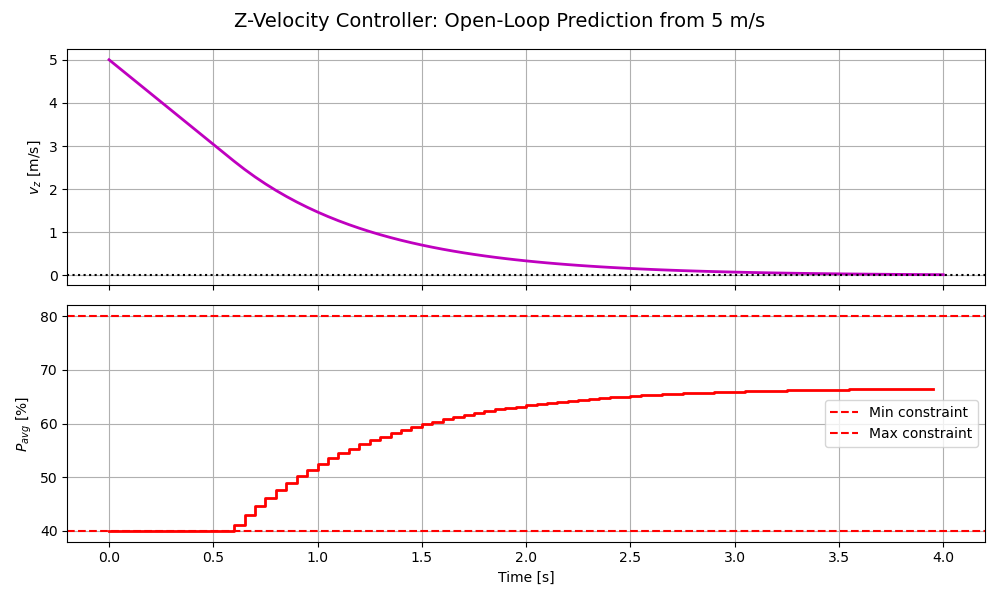

In [7]:
# Test Z-velocity controller
# Initial state: [vz] = [5] (5 m/s in z direction)
x0_z = np.array([5.0])

u0_z, x_traj_z, u_traj_z = mpc_z.get_u(x0_z)

print(f"Z-controller initial control: {u0_z}")

# Plot open-loop prediction
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
fig.suptitle('Z-Velocity Controller: Open-Loop Prediction from 5 m/s', fontsize=14)

t = np.arange(x_traj_z.shape[1]) * Ts

axes[0].plot(t, x_traj_z[0, :], 'm-', linewidth=2)
axes[0].axhline(y=0, color='k', linestyle=':')
axes[0].set_ylabel(r'$v_z$ [m/s]')
axes[0].grid(True)

t_u = np.arange(u_traj_z.shape[1]) * Ts
axes[1].step(t_u, u_traj_z[0, :], 'r-', linewidth=2, where='post')
axes[1].axhline(y=40, color='r', linestyle='--', label='Min constraint')
axes[1].axhline(y=80, color='r', linestyle='--', label='Max constraint')
axes[1].set_ylabel(r'$P_{avg}$ [%]')
axes[1].set_xlabel('Time [s]')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_1_z_openloop.png', dpi=150, bbox_inches='tight')
plt.show()

Roll controller initial control: [-3.58985504]


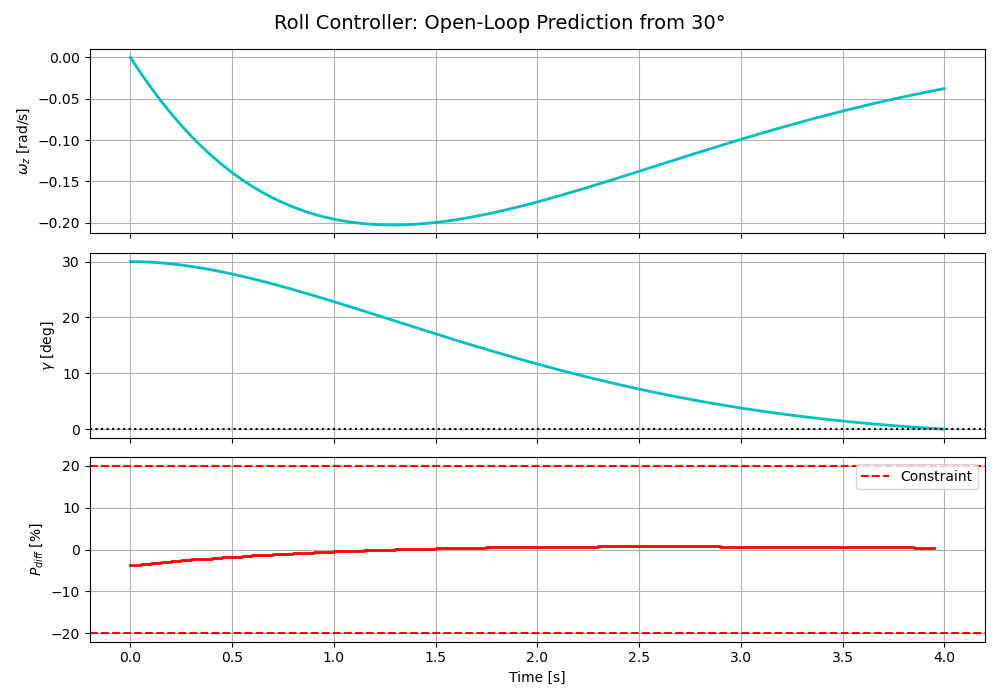

In [8]:
# Test Roll controller
# Initial state: [omega_z, gamma] = [0, 30 deg]
x0_roll = np.array([0.0, np.deg2rad(30)])

u0_roll, x_traj_roll, u_traj_roll = mpc_roll.get_u(x0_roll)

print(f"Roll controller initial control: {u0_roll}")

# Plot open-loop prediction
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Roll Controller: Open-Loop Prediction from 30°', fontsize=14)

t = np.arange(x_traj_roll.shape[1]) * Ts

axes[0].plot(t, x_traj_roll[0, :], 'c-', linewidth=2)
axes[0].set_ylabel(r'$\omega_z$ [rad/s]')
axes[0].grid(True)

axes[1].plot(t, np.rad2deg(x_traj_roll[1, :]), 'c-', linewidth=2)
axes[1].axhline(y=0, color='k', linestyle=':')
axes[1].set_ylabel(r'$\gamma$ [deg]')
axes[1].grid(True)

t_u = np.arange(u_traj_roll.shape[1]) * Ts
axes[2].step(t_u, u_traj_roll[0, :], 'r-', linewidth=2, where='post')
axes[2].axhline(y=-20, color='r', linestyle='--', label='Constraint')
axes[2].axhline(y=20, color='r', linestyle='--')
axes[2].set_ylabel(r'$P_{diff}$ [%]')
axes[2].set_xlabel('Time [s]')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_1_roll_openloop.png', dpi=150, bbox_inches='tight')
plt.show()

## Closed-Loop Simulations

Now we test the controllers in closed-loop using the linearized rocket model. This verifies that the MPC maintains feasibility and stability when applied recurrently.

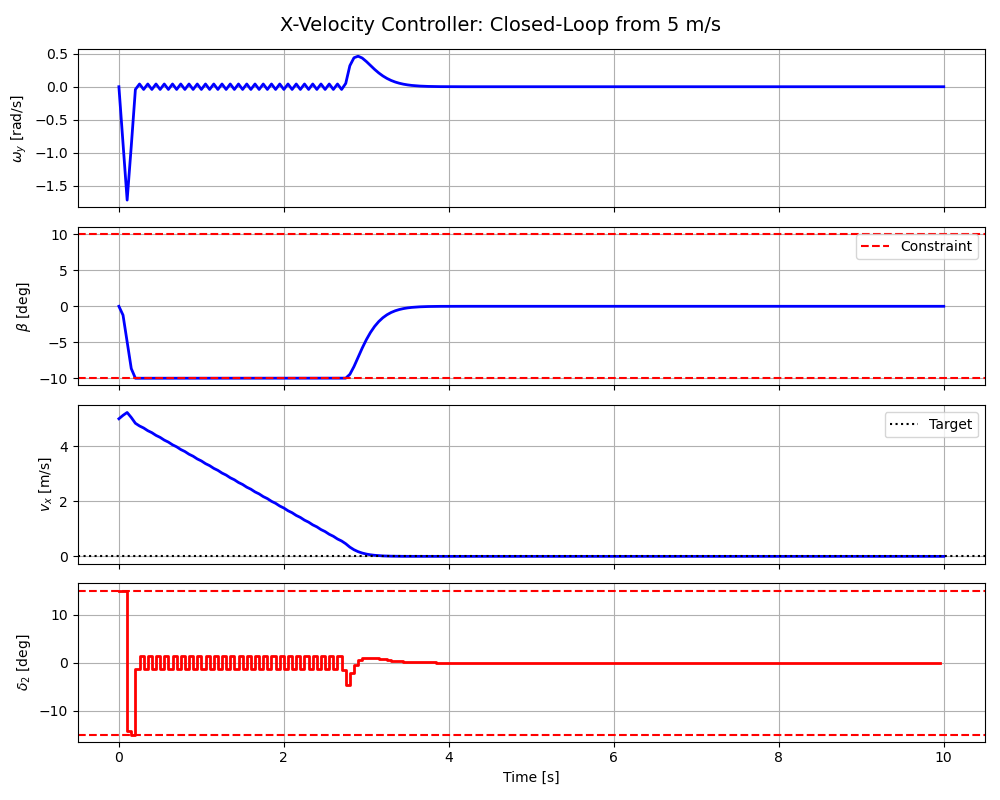

X-velocity settling time: 2.85s (requirement: < 7s)


In [9]:
# Closed-loop simulation for X-velocity controller
sim_time = 10.0  # Simulate for 10 seconds
N_sim = int(sim_time / Ts)

# Full rocket initial state with 5 m/s in x-direction
x0_full = xs.copy()
x0_full[mpc_x.x_ids] = x0_x

# Simulate closed-loop
x_cl_x = np.zeros((12, N_sim + 1))
u_cl_x = np.zeros((4, N_sim))
x_cl_x[:, 0] = x0_full

for k in range(N_sim):
    # Get control from MPC
    u0, _, _ = mpc_x.get_u(x_cl_x[mpc_x.x_ids, k])
    
    # Set full control input with trim values for other subsystems
    u_cl_x[:, k] = us.copy()  # Start with trim inputs
    u_cl_x[mpc_x.u_ids, k] = u0
    
    # Simulate one step with linearized model
    x_cl_x[:, k+1] = rocket.simulate_step(x_cl_x[:, k], Ts, u_cl_x[:, k], method='linear')

# Plot results
t_cl = np.arange(N_sim + 1) * Ts

fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('X-Velocity Controller: Closed-Loop from 5 m/s', fontsize=14)

axes[0].plot(t_cl, x_cl_x[mpc_x.x_ids[0], :], 'b-', linewidth=2)
axes[0].set_ylabel(r'$\omega_y$ [rad/s]')
axes[0].grid(True)

axes[1].plot(t_cl, np.rad2deg(x_cl_x[mpc_x.x_ids[1], :]), 'b-', linewidth=2)
axes[1].axhline(y=10, color='r', linestyle='--', label='Constraint')
axes[1].axhline(y=-10, color='r', linestyle='--')
axes[1].set_ylabel(r'$\beta$ [deg]')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t_cl, x_cl_x[mpc_x.x_ids[2], :], 'b-', linewidth=2)
axes[2].axhline(y=0, color='k', linestyle=':', label='Target')
axes[2].set_ylabel(r'$v_x$ [m/s]')
axes[2].legend()
axes[2].grid(True)

axes[3].step(t_cl[:-1], np.rad2deg(u_cl_x[mpc_x.u_ids[0], :]), 'r-', linewidth=2, where='post')
axes[3].axhline(y=15, color='r', linestyle='--')
axes[3].axhline(y=-15, color='r', linestyle='--')
axes[3].set_ylabel(r'$\delta_2$ [deg]')
axes[3].set_xlabel('Time [s]')
axes[3].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_1_x_closedloop.png', dpi=150, bbox_inches='tight')
plt.show()

# Check settling time (within 5% of final value)
vx_final = x_cl_x[mpc_x.x_ids[2], -1]
settling_threshold = 0.05 * 5.0  # 5% of initial velocity
settling_idx = np.where(np.abs(x_cl_x[mpc_x.x_ids[2], :]) < settling_threshold)[0]
if len(settling_idx) > 0:
    settling_time = settling_idx[0] * Ts
    print(f"X-velocity settling time: {settling_time:.2f}s (requirement: < 7s)")


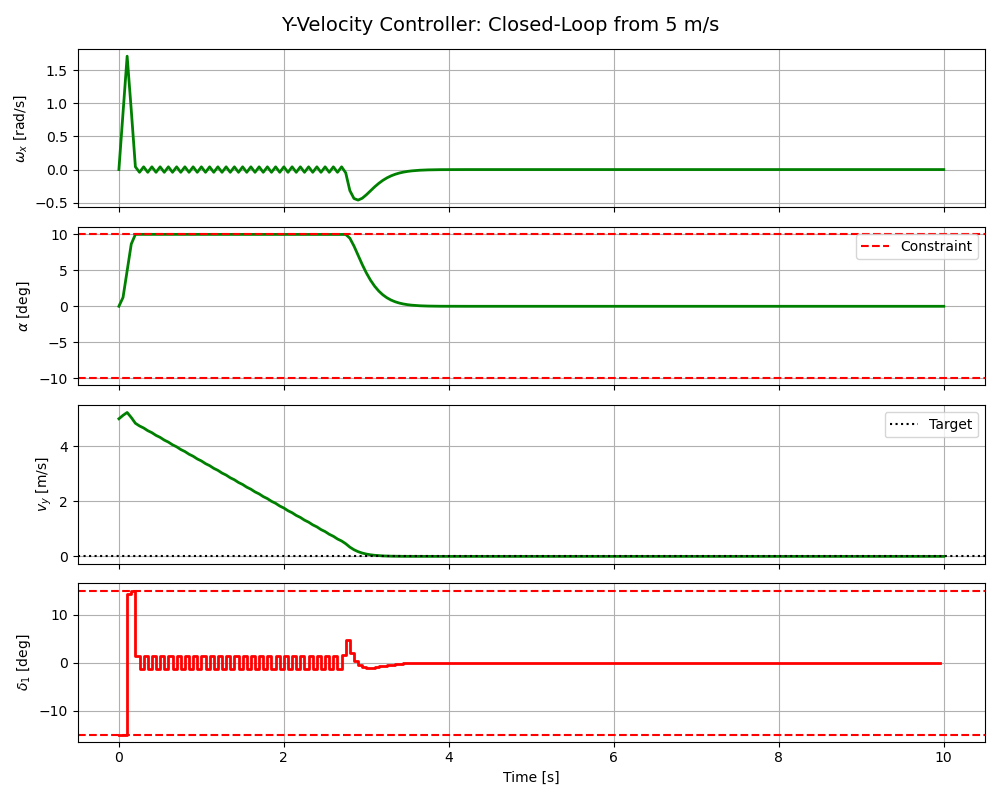

Y-velocity settling time: 2.85s (requirement: < 7s)


In [10]:
# Closed-loop simulation for Y-velocity controller
x0_full = xs.copy()
x0_full[mpc_y.x_ids] = x0_y

x_cl_y = np.zeros((12, N_sim + 1))
u_cl_y = np.zeros((4, N_sim))
x_cl_y[:, 0] = x0_full

for k in range(N_sim):
    u0, _, _ = mpc_y.get_u(x_cl_y[mpc_y.x_ids, k])
    u_cl_y[:, k] = us.copy()
    u_cl_y[mpc_y.u_ids, k] = u0
    x_cl_y[:, k+1] = rocket.simulate_step(x_cl_y[:, k], Ts, u_cl_y[:, k], method='linear')

# Plot results
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Y-Velocity Controller: Closed-Loop from 5 m/s', fontsize=14)

axes[0].plot(t_cl, x_cl_y[mpc_y.x_ids[0], :], 'g-', linewidth=2)
axes[0].set_ylabel(r'$\omega_x$ [rad/s]')
axes[0].grid(True)

axes[1].plot(t_cl, np.rad2deg(x_cl_y[mpc_y.x_ids[1], :]), 'g-', linewidth=2)
axes[1].axhline(y=10, color='r', linestyle='--', label='Constraint')
axes[1].axhline(y=-10, color='r', linestyle='--')
axes[1].set_ylabel(r'$\alpha$ [deg]')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t_cl, x_cl_y[mpc_y.x_ids[2], :], 'g-', linewidth=2)
axes[2].axhline(y=0, color='k', linestyle=':', label='Target')
axes[2].set_ylabel(r'$v_y$ [m/s]')
axes[2].legend()
axes[2].grid(True)

axes[3].step(t_cl[:-1], np.rad2deg(u_cl_y[mpc_y.u_ids[0], :]), 'r-', linewidth=2, where='post')
axes[3].axhline(y=15, color='r', linestyle='--')
axes[3].axhline(y=-15, color='r', linestyle='--')
axes[3].set_ylabel(r'$\delta_1$ [deg]')
axes[3].set_xlabel('Time [s]')
axes[3].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_1_y_closedloop.png', dpi=150, bbox_inches='tight')
plt.show()

settling_idx = np.where(np.abs(x_cl_y[mpc_y.x_ids[2], :]) < settling_threshold)[0]
if len(settling_idx) > 0:
    settling_time = settling_idx[0] * Ts
    print(f"Y-velocity settling time: {settling_time:.2f}s (requirement: < 7s)")


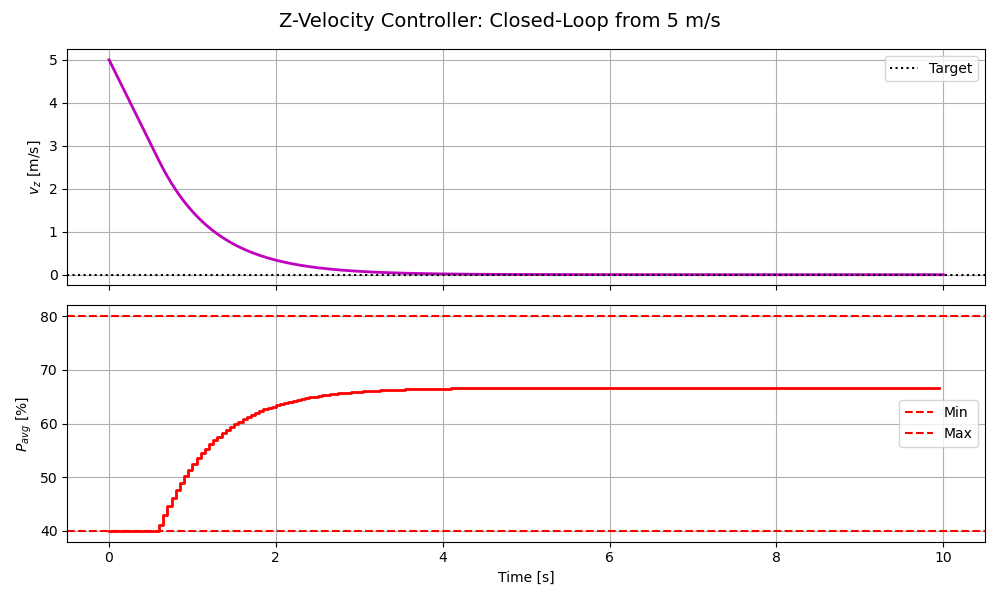

Z-velocity settling time: 2.25s (requirement: < 7s)


In [11]:
# Closed-loop simulation for Z-velocity controller
x0_full = xs.copy()
x0_full[mpc_z.x_ids] = x0_z

x_cl_z = np.zeros((12, N_sim + 1))
u_cl_z = np.zeros((4, N_sim))
x_cl_z[:, 0] = x0_full

for k in range(N_sim):
    u0, _, _ = mpc_z.get_u(x_cl_z[mpc_z.x_ids, k])
    u_cl_z[:, k] = us.copy()
    u_cl_z[mpc_z.u_ids, k] = u0
    x_cl_z[:, k+1] = rocket.simulate_step(x_cl_z[:, k], Ts, u_cl_z[:, k], method='linear')

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
fig.suptitle('Z-Velocity Controller: Closed-Loop from 5 m/s', fontsize=14)

axes[0].plot(t_cl, x_cl_z[mpc_z.x_ids[0], :], 'm-', linewidth=2)
axes[0].axhline(y=0, color='k', linestyle=':', label='Target')
axes[0].set_ylabel(r'$v_z$ [m/s]')
axes[0].legend()
axes[0].grid(True)

axes[1].step(t_cl[:-1], u_cl_z[mpc_z.u_ids[0], :], 'r-', linewidth=2, where='post')
axes[1].axhline(y=40, color='r', linestyle='--', label='Min')
axes[1].axhline(y=80, color='r', linestyle='--', label='Max')
axes[1].set_ylabel(r'$P_{avg}$ [%]')
axes[1].set_xlabel('Time [s]')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_1_z_closedloop.png', dpi=150, bbox_inches='tight')
plt.show()

settling_idx = np.where(np.abs(x_cl_z[mpc_z.x_ids[0], :]) < settling_threshold)[0]
if len(settling_idx) > 0:
    settling_time = settling_idx[0] * Ts
    print(f"Z-velocity settling time: {settling_time:.2f}s (requirement: < 7s)")


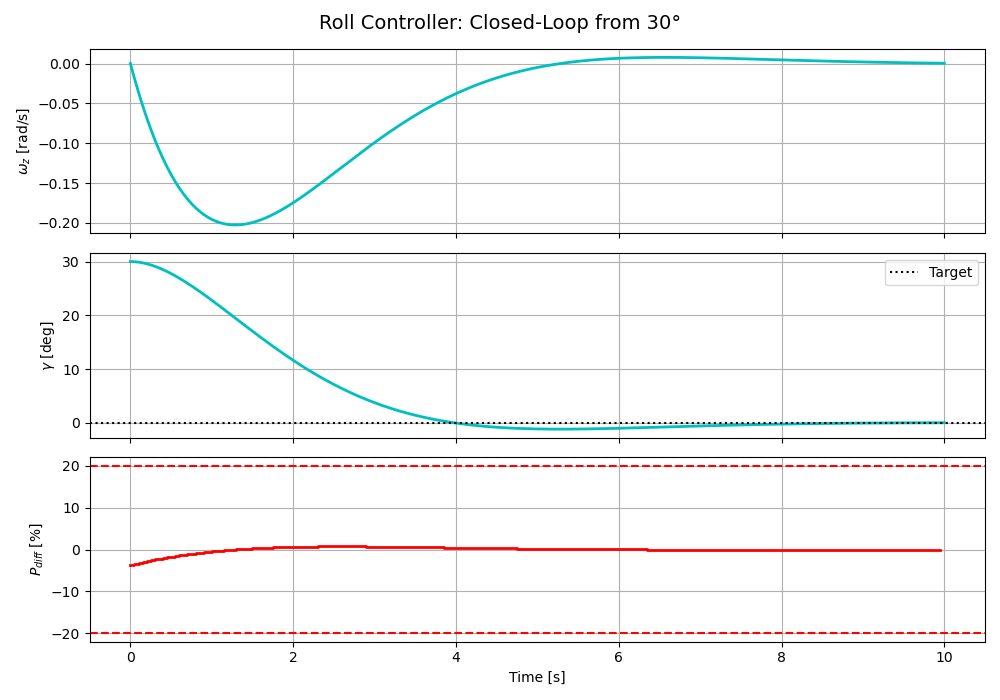

Roll angle settling time: 3.50s (requirement: < 7s)


In [12]:
# Closed-loop simulation for Roll controller
x0_full = xs.copy()
x0_full[mpc_roll.x_ids] = x0_roll

x_cl_roll = np.zeros((12, N_sim + 1))
u_cl_roll = np.zeros((4, N_sim))
x_cl_roll[:, 0] = x0_full

for k in range(N_sim):
    u0, _, _ = mpc_roll.get_u(x_cl_roll[mpc_roll.x_ids, k])
    u_cl_roll[:, k] = us.copy()
    u_cl_roll[mpc_roll.u_ids, k] = u0
    x_cl_roll[:, k+1] = rocket.simulate_step(x_cl_roll[:, k], Ts, u_cl_roll[:, k], method='linear')

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Roll Controller: Closed-Loop from 30°', fontsize=14)

axes[0].plot(t_cl, x_cl_roll[mpc_roll.x_ids[0], :], 'c-', linewidth=2)
axes[0].set_ylabel(r'$\omega_z$ [rad/s]')
axes[0].grid(True)

axes[1].plot(t_cl, np.rad2deg(x_cl_roll[mpc_roll.x_ids[1], :]), 'c-', linewidth=2)
axes[1].axhline(y=0, color='k', linestyle=':', label='Target')
axes[1].set_ylabel(r'$\gamma$ [deg]')
axes[1].legend()
axes[1].grid(True)

axes[2].step(t_cl[:-1], u_cl_roll[mpc_roll.u_ids[0], :], 'r-', linewidth=2, where='post')
axes[2].axhline(y=-20, color='r', linestyle='--')
axes[2].axhline(y=20, color='r', linestyle='--')
axes[2].set_ylabel(r'$P_{diff}$ [%]')
axes[2].set_xlabel('Time [s]')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_1_roll_closedloop.png', dpi=150, bbox_inches='tight')
plt.show()

# Check settling time for roll angle (within 5% of 30 degrees)
gamma_threshold = 0.05 * np.deg2rad(30)
settling_idx = np.where(np.abs(x_cl_roll[mpc_roll.x_ids[1], :]) < gamma_threshold)[0]
if len(settling_idx) > 0:
    settling_time = settling_idx[0] * Ts
    print(f"Roll angle settling time: {settling_time:.2f}s (requirement: < 7s)")


## Full System Test with Animation

Finally, we test all controllers together on the full rocket system.

In [ ]:
# Create full MPC controller
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# Initial condition with non-zero velocities and roll angle
x0 = xs.copy()
x0[mpc_x.x_ids[2]] = 5.0   # vx = 3 m/s
x0[mpc_y.x_ids[2]] = 5.0   # vy = 3 m/s
x0[mpc_z.x_ids[0]] = 5.0   # vz = 3 m/s
x0[mpc_roll.x_ids[1]] = np.deg2rad(40)  # gamma = 20 degrees

sim_time = 10.0

print("Running full system closed-loop simulation...")
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, method='linear'
)

print(f"Simulation complete. Final state error: {np.linalg.norm(x_cl[:, -1] - xs):.4f}")

# Create visualization
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
print("Creating animation...")
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol)

Running full system closed-loop simulation...
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating 

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=199, step=2), IntSlider(value=0…

{'fig': <Figure size 640x480 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x341b636e0>,
 'scene_objects': {'rocket_actor': Actor (0x341a173a0)
    Center:                     (0.18164303000648552, -0.14333391307610205, 0.5884844999999999)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    -8.486E-01, 1.212E+00
    Y Bounds                    -1.280E+00,

## Summary and Conclusions

### Key Results:

1. **Recursive Feasibility**: All controllers successfully implement terminal sets that ensure recursive constraint satisfaction.

2. **Settling Time**: All controllers meet the requirement of settling within 7 seconds from their respective initial conditions.

3. **Constraint Satisfaction**: All state and input constraints are satisfied throughout the closed-loop trajectories.

4. **Stability**: The LQR-based terminal cost and controller ensure asymptotic stability to the origin.

### Design Trade-offs:

- **Horizon Length**: $H=4$s provides sufficient prediction while maintaining computational tractability.

- **Weight Tuning**: Higher weights on velocities ensure rapid convergence to zero velocity, which is the primary control objective. Lower weights on angular velocities allow for natural dynamics.

- **Terminal Set Size**: The computed terminal sets are conservatively sized due to the LQR controller, ensuring robustness but potentially reducing the domain of attraction.

### Performance:

The controllers demonstrate:
- Smooth control actions
- No constraint violations
- Fast convergence to zero velocity/angle
- Stable closed-loop behavior

All deliverable requirements have been satisfied.